### Import knihoven a konfigurace

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display

from scipy.spatial import distance

%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### Pomocné funkce

In [2]:
def select_image_points(img, points_cnt = 4):
    """ Opens a new image window, where user can interactively add or remove image points.
    Points are added while holding CTRL key + pressing left mouse button and removed by ALT key + pressing left mouse button.
    The point selection is terminated by pressing the 'q' key.
    
    Parameters
    ----------
    img : ndarray
        Input image where image points are choosen and drawn.
    points_cnt : Optional[int]
        A maximum number of points to choose. A minimum number of points to compute the projective transformation is 4.
    Returns
    -------
    list
        Returns a list of size >= 4 and size <= points_cnt such that each elements represent (x, y) coordinate in input image.
    """
    if points_cnt < 4: 
        raise ValueError('Number of points must be >= 4.')
        
    points = []
    window_name = 'Point selection'
    img_dimensions = img.shape[:2]
    pts_dist_thresh = 0.01 * img_dimensions[1] # Scale drawing elements with image size
    
    def draw_circle(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            if flags == cv2.EVENT_FLAG_ALTKEY + cv2.EVENT_LBUTTONDOWN: 
                for p in points:
                    if distance.euclidean(p, (x, y)) < pts_dist_thresh:
                        points.remove(p)
                        break
            elif flags == cv2.EVENT_FLAG_CTRLKEY + cv2.EVENT_LBUTTONDOWN and len(points) < points_cnt:
                points.append((x, y))           

    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL | cv2.WINDOW_GUI_NORMAL)
    cv2.resizeWindow(window_name, 1080, 720)
    cv2.moveWindow(window_name, 0, 0)
    cv2.setMouseCallback(window_name, draw_circle)
    
    # Drawing section, scale drawing elements with image size
    circle_diam = int(0.003 * img_dimensions[1])
    lbl_offset = int(0.005 * img_dimensions[1])
    lbl_font_scale = (0.001 * img_dimensions[1])
    lbl_thickness = int(0.003 * img_dimensions[1])
    
    while 1:
        drawn_img = img.copy()
        
        for i, p in enumerate(points):
            cv2.circle(drawn_img, p, circle_diam , (0, 0, 255), cv2.FILLED)
            cv2.putText(drawn_img, str(i), (p[0] + circle_diam + lbl_offset, p[1] + circle_diam + lbl_offset),
                        0, lbl_font_scale, (0, 0, 255), lbl_thickness)
            
        cv2.imshow(window_name, drawn_img)
        k = cv2.waitKey(1) & 0xFF
        
        if k == ord('q'):
            break

    cv2.destroyAllWindows()
    
    if len(points) < 4: 
        raise ValueError('Number of choosen points must be >= 4.')
        
    return points

In [3]:
def show_images(*imgs, window_name='Image preview'):
    """ Opens multiple image previews depending on the length of the input *imgs list.
    The preview is terminated by pressing the 'q' key.
    
    Parameters
    ----------
    *imgs : list
        Multiple input images which have to be shown.
    window_name : Optional[string]
        An optional window name.
    Returns
    -------
    None
    """
    for i, img in enumerate(imgs, 1):
        window_name_id = window_name + ' ' + str(i)
        cv2.namedWindow(window_name_id, cv2.WINDOW_NORMAL | cv2.WINDOW_GUI_NORMAL)
        cv2.resizeWindow(window_name_id, 1080, 720)
        cv2.moveWindow(window_name_id, 0, 0)

    while 1:
        for i, img in enumerate(imgs, 1):
            cv2.imshow(window_name + ' ' + str(i), img)
            
        k = cv2.waitKey(1) & 0xFF

        if k == ord('q'):
            break

    cv2.destroyAllWindows()

## Úkol

Vzhledem k ohlasům na časovou náročnost prvního úkolu jsem se rozhodl provést experimentální ulehčení. Pokud jste byli na cvičení, tak by vám to tentokrát opravdu nemělo zabrat moc času - pro jistotu už ale neříkám žádné odhady. Za případný feedback a informaci o době trvání budeme rádi!

Výchozím bodem k tomuto úkolu je [toto cvičení](https://gitlab.fit.cvut.cz/bi-svz/bi-svz/blob/master/tutorials/files/5/perspective-measuring-cont.ipynb).

### První část - rovnání dokumentu a následná aplikace OCR
Práce probíhá se souborem `ocr_img.jpg` na kterém se nachází dokument známých rozměrů (papír A4). Dokument je potřeba transformovat na kolmý pohled a následně využít Google Cloud Vision API k automatizovanému přečtení textu pomocí OCR. Za tuto část je možné získat maximálně **3 body** a **až 1 prémiový**.

![](ocr_img.jpg)

**1) Načtěte obrázek, zobrazte ho a uložte si pole cílových korespondečních souřadnic rohů dokumentu.**

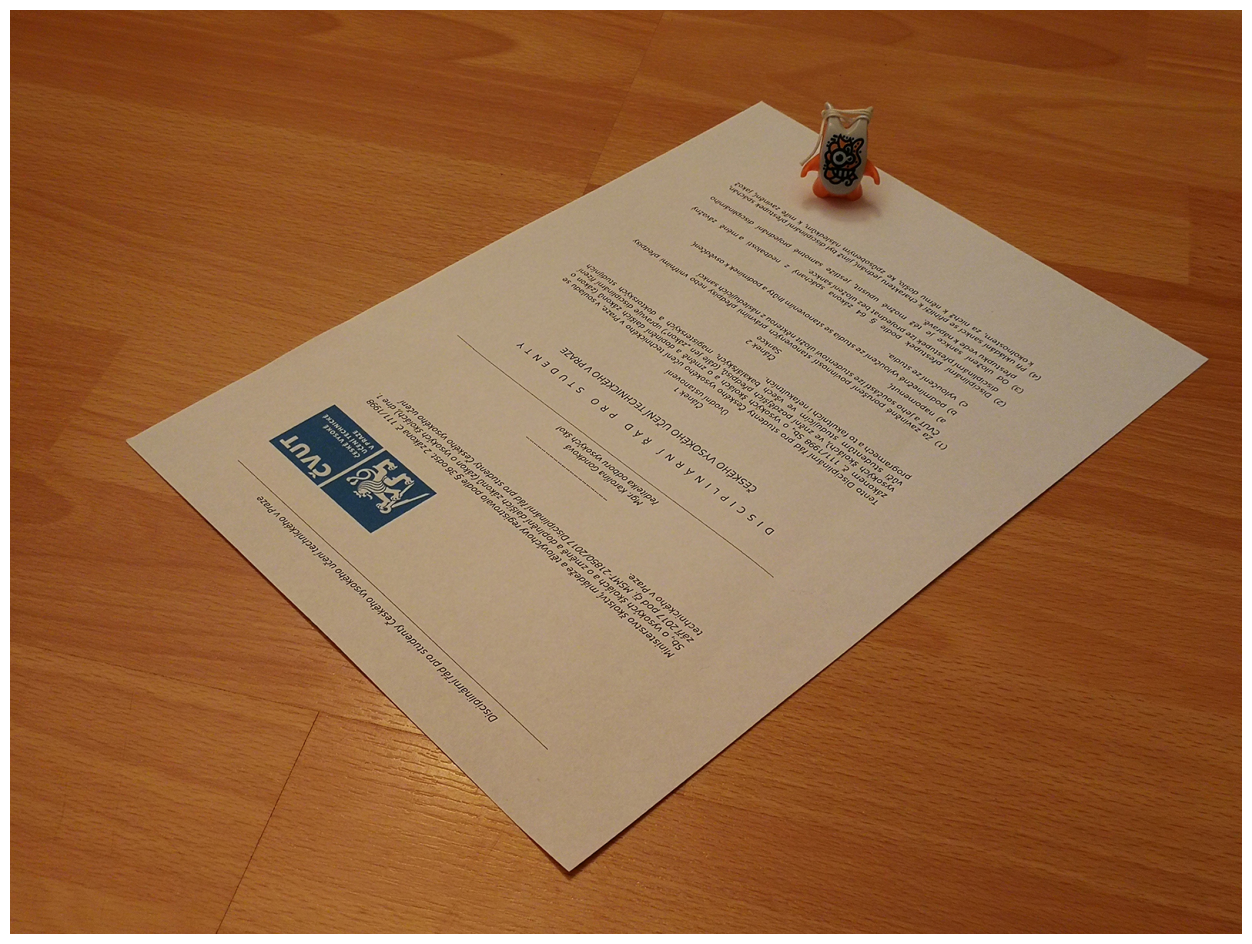

In [4]:
from improutils import *
image = load_image("ocr_img.jpg")
plot_images(image)

mul = 10
real_world_pts = np.array([(0,0), (297*mul, 0), (297*mul,210*mul), (0,210*mul)])

**2) Pomocí již hotové funkce `select_image_points()` vyberte obrazové souřadnice rohů dokumentu.**  
Souřadnice musí korespondovat pořadím, takže pokud je levý roh první v předchozím poli, musí být první vybrán i v tomto kroku.

In [5]:
image_pts = np.array([(151, 560),(975, 118),(1556, 453),(726, 1118)])

if (len(image_pts) != len(real_world_pts)):
    raise ValueError('Real world points and image points must be the same size.')

print('format: x, y \n', image_pts)

format: x, y 
 [[ 151  560]
 [ 975  118]
 [1556  453]
 [ 726 1118]]


**3) Vypočtěte transformační matici H, vypište její tvar.**

In [6]:
H, mask = H, mask = cv2.findHomography(image_pts, real_world_pts) ###
print(H.shape)

(3, 3)


**4) Popište rozdíl mezi [`cv2.getPerspectiveTransform()`](https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#ga8c1ae0e3589a9d77fffc962c49b22043) a [`cv2.findHomography`](https://docs.opencv.org/3.4.1/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780).**

.

**5) Využijte funkci [`cv2.warpPerspective`](https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) k vytvoření kolmého pohledu dokumentu, výsledek zobrazte a uložte.**

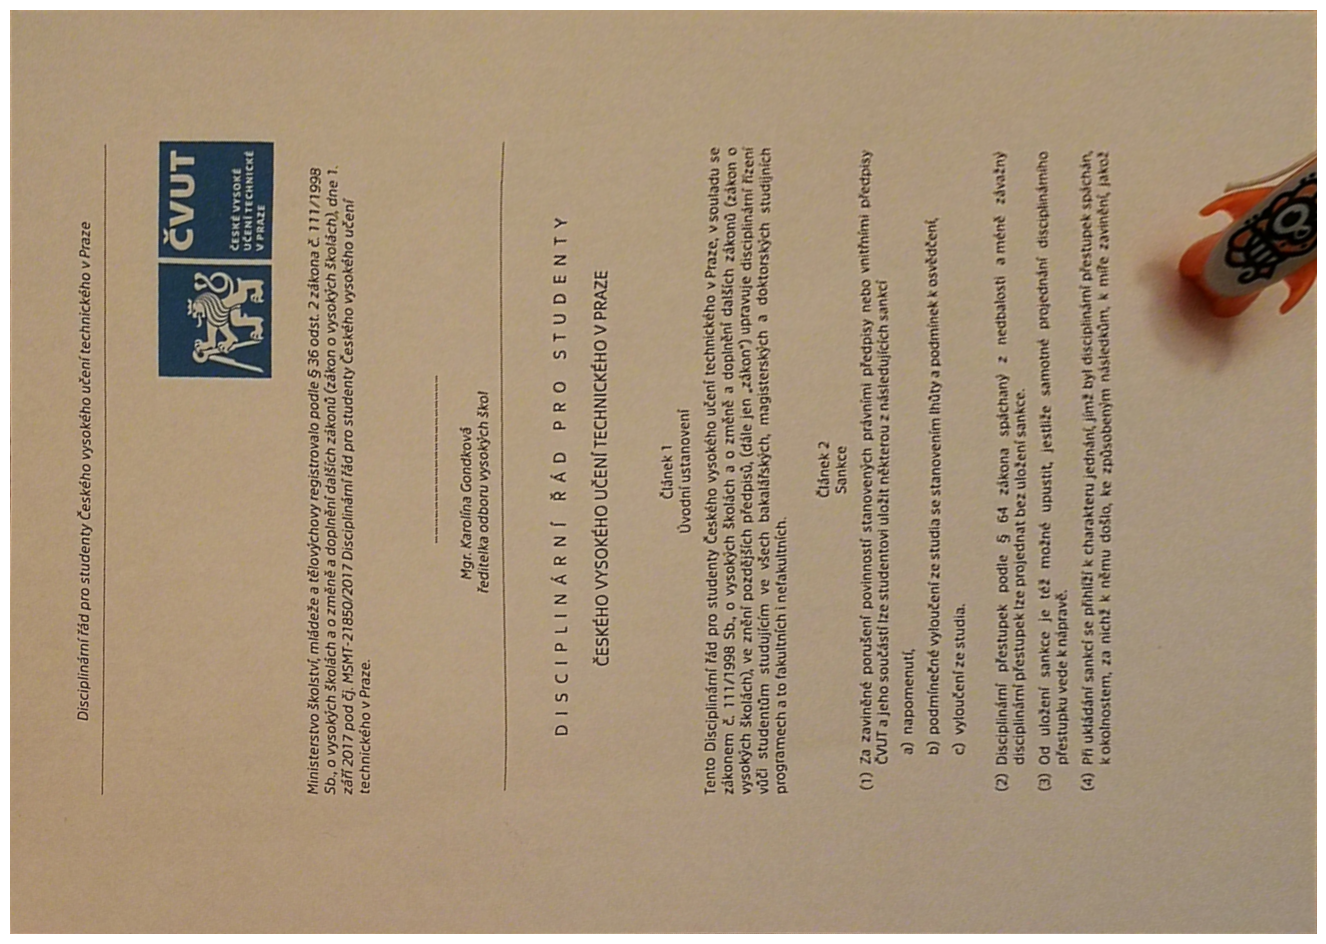

In [7]:
warped_img = cv2.warpPerspective(image, H,(297*mul, 210*mul))
plot_images(warped_img)

In [8]:
save_image(warped_img, "warped_img.png")

True

**6) Zprovozněte si účet na Google Cloudu, abyste mohli využívat službu Cloud Vision API.**

K aktivaci využijte fakultní emailový účet a odkaz, který jsem vám zaslal emailem. Službu Vision je pak nutné explicitně aktivovat v nastavení a ve svém lokálním Python prostředí doinstalovat některé závislosti pomocí příkazu `pip install`. Posledním krokem je vytvoření přístupových údaju v Google Cloudu a stažení API klíče (idealně ve formátu JSON). Blizší detaily o zprovoznění naleznete na https://cloud.google.com/vision/docs/.

**API KLÍČ DO REPOZITÁŘE NEPUSHUJTE.** Přidejte si ho třeba do .gitignore.


**7) Detekujte text na "narovnaném" obraze pomocí níže uvedené funkce, text vypiště a uložte do textového souboru.** 

In [9]:
def ocr_google(img_path):
    """Detects text in the file."""
    from google.cloud.vision_v1.types import Image
    from google.cloud import vision
    import io
    import os
    
    api_key = 'api-key.json'
    assert os.path.exists(api_key), 'There is no API-KEY in your path! You need to contact google to get one.'
    client = vision.ImageAnnotatorClient.from_service_account_json(api_key)
    
    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()

    image = Image(content=content)
    response = client.text_detection(image=image)
    annotations = response.text_annotations

    return annotations

In [10]:
text_unmod = str(ocr_google("warped_img.png")[0])

In [11]:
text = text_unmod[text_unmod.find("description"):]
text = text[text.find('"')+1:]
text = text[:text.find('bounding_poly {')-2]
lines = text.split("\\n")
new_text = '\n'.join(lines)
print(new_text)

Disciplinární řád pro studenty Českého vysokého učení technického v Praze
Mgr. Karolina Gondková
ředitelka odboru vysokých škol
Ministerstvo školství, mládeže a tělovýchovy registrovalo podle § 36 odst. 2 zákona č. 111/1998
Sb., o vysokých školách a o změně a doplnění dalších zákonů (zákon o vysokých školách), dne 1.
září 2017 pod čj. MSMT-21850/2017 Disciplinární řád pro studenty Českého vysokého učení
technického v Praze.
8
Článek 1
Úvodní ustanovení
DISCIPLINÁRNÍ ŘÁD PRO STUDENTY
ČESKÉHO VYSOKÉHO UČENÍ TECHNICKÉHO V PRAZE
CVUT
ČESKÉ VYSOKÉ
UČENÍ TECHNICKÉ
V PRAZE
Článek 2
Sankce
Tento Disciplinární řád pro studenty Českého vysokého učení technického v Praze, v souladu se
zákonem č. 111/1998 Sb., o vysokých školách a o změně a doplnění dalších zákonů (zákon o
vysokých školách), ve znění pozdějších předpisů, (dále jen „zákon\") upravuje disciplinární řízení
vůči studentům studujícím ve všech bakalářských, magisterských a doktorských studijních
programech a to fakultních i nefakultních

In [12]:
f = open("text.txt", 'a', encoding='utf-8')
f.write(new_text)
f.close()

#### Bonus k první části
Jak je vidět, výsledky po aplikaci OCR nejsou zcela uspokojivé. Je však v nutné brát potaz, že vstupní obraz není kromě geometrické transformace nijak dále předzpracován. Vzpomeňte si na cvičení, kde jsme aplikovali OCR s knihovnou Tesseract. Tam byly poměrně přísné nároky na vstupní obraz, který musel být perfektně předzpracovaný a v binární podobě. Tesseract je citlivý i na drobné natočení nebo deformování textu. Řešení od Google je v tomto ohledu značně robustnější.

**8) Pokuste se vstupní obraz před aplikací OCR kvalitněji předzpracovat pomocí probíraných technik - crop, segmentace, zaostření, rozmazání, jas, kontrast, apod. Fantazii se meze nekladou. Stručně diskutujte poznatky a vlivy jednotlivých operací na výslednou kvalitu. <span style="color:blue">(0.5 bodu)</span>**

**9) Využijte Google Cloud Translate API k přeložení výsledného textu do angličtiny, výsledek zobrazte a uložte do textového souboru. <span style="color:blue">(0.5 bodu)</span>**

### Druhá část - výtvarné umění na FITu
Práce probíhá s fotografií `fit_budova.jpg` od autora Tomáše Kouby a s malbou `fit_logo.jpg` od autora Lukáš Brchla. Cílem je umístit obrázek loga na stěnu budovy FITu viz obrázek. Za tuto část je možné získat maximálně **3 body** a **až 1 prémiový**.

![](fit_logo_merged.jpg)

**1) Načtěte obrázky a vytvořte pole korespondečních souřadnic rohů malby.**

[[  0   0]
 [  0 719]
 [141 719]
 [141   0]]


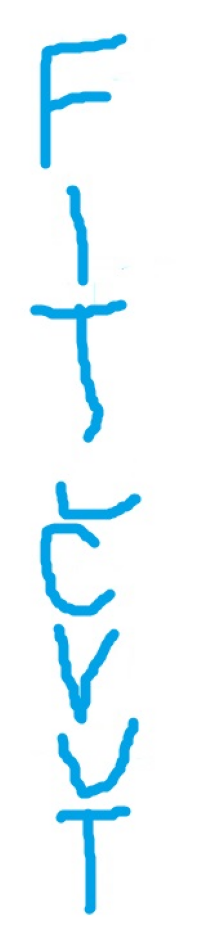

In [13]:
main_img = load_image("fit_budova.jpg")
logo_img = load_image("fit_logo.jpg")
logo_pts = np.array([(0,0), (0, logo_img.shape[0]),(logo_img.shape[1], logo_img.shape[0]),(logo_img.shape[1], 0)])
print(logo_pts)
plot_images(logo_img)

**2) Vyberte souřadnice v obraze, do kterých má být logo transformováno (pozor na pořadí).**

In [15]:
image_pts = np.array([(189, 25), (68, 415), (173, 413), (251, 66)])
if (len(image_pts) != len(logo_pts)):
    raise ValueError('Real world points and image points must be the same size.')

print('format: x, y \n', image_pts)

format: x, y 
 [[189  25]
 [ 68 415]
 [173 413]
 [251  66]]


**3) Vypočtěte transformační matici H, vypište její tvar.**

In [16]:
H, mask = cv2.findHomography(logo_pts, image_pts)

**4) Využijte funkci `cv2.warpPerspective()` k vytvoření stejné perspektivy loga jako fotografie budovy. Zobrazte výsledky.**

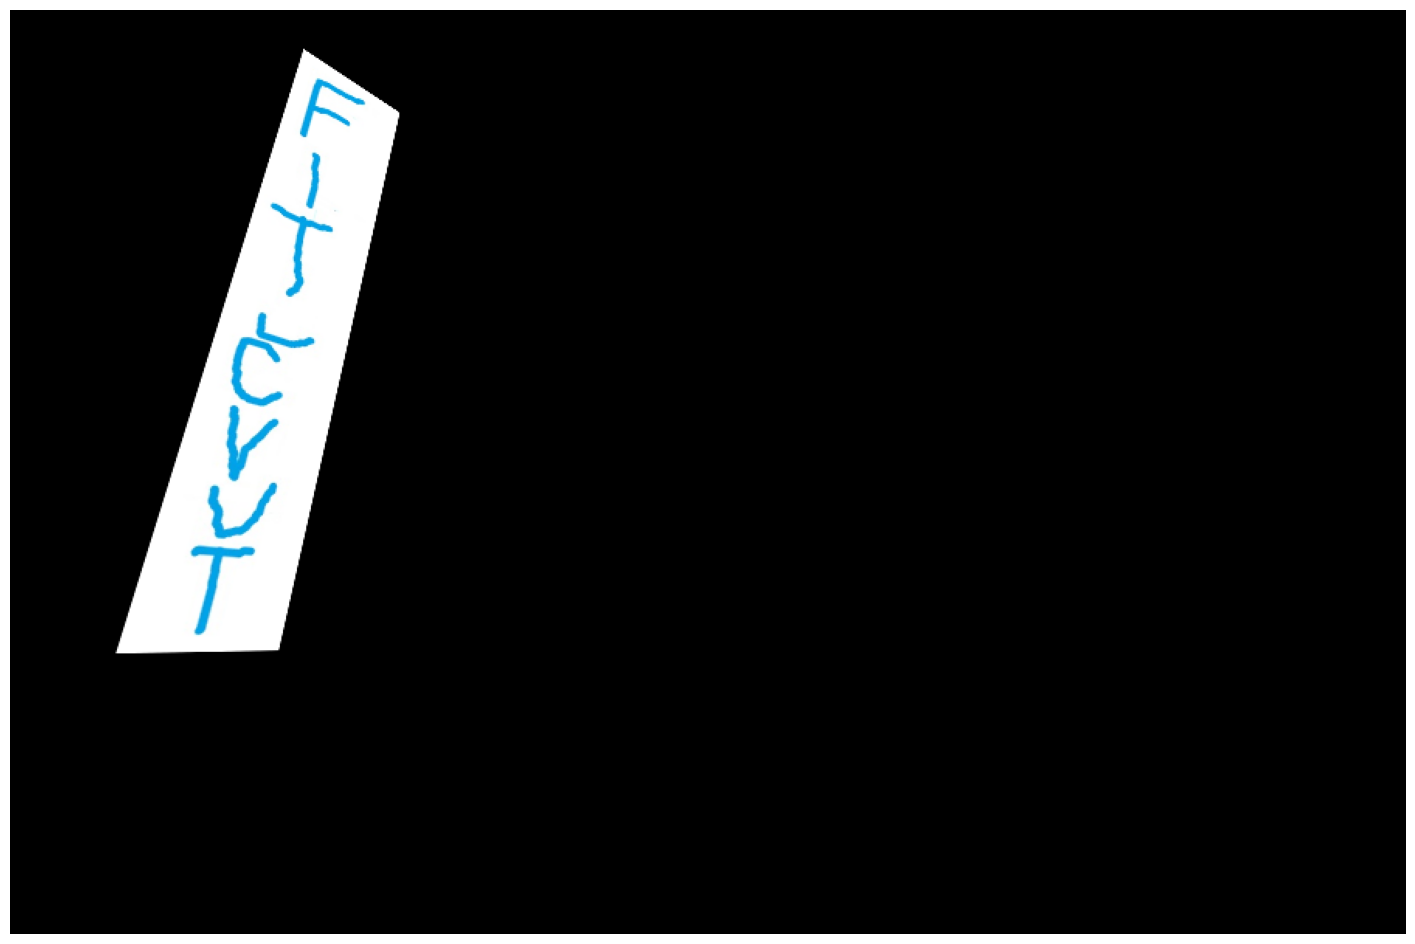

In [17]:
warped2 = cv2.warpPerspective(logo_img, H, (main_img.shape[1], main_img.shape[0]))
plot_images(warped2)

**5) Logo je nutné umístit na budovu bez bílého pozadí, je tedy nutné ho segmentovat.**

Tady se mohou vaše postupy lišit. Kvalita segmentace následně razantně rozhoduje o kvalitě výsledku. Zkuste experimentovat s různými druhy segmentace a zkuste využít i nějaké funkce pro předzpracování, jako např. rozmazání. Může se vám hodit funkce `cv2.bitwise_and`.

In [18]:
waarp = cv2.blur(warped2, (4,4))

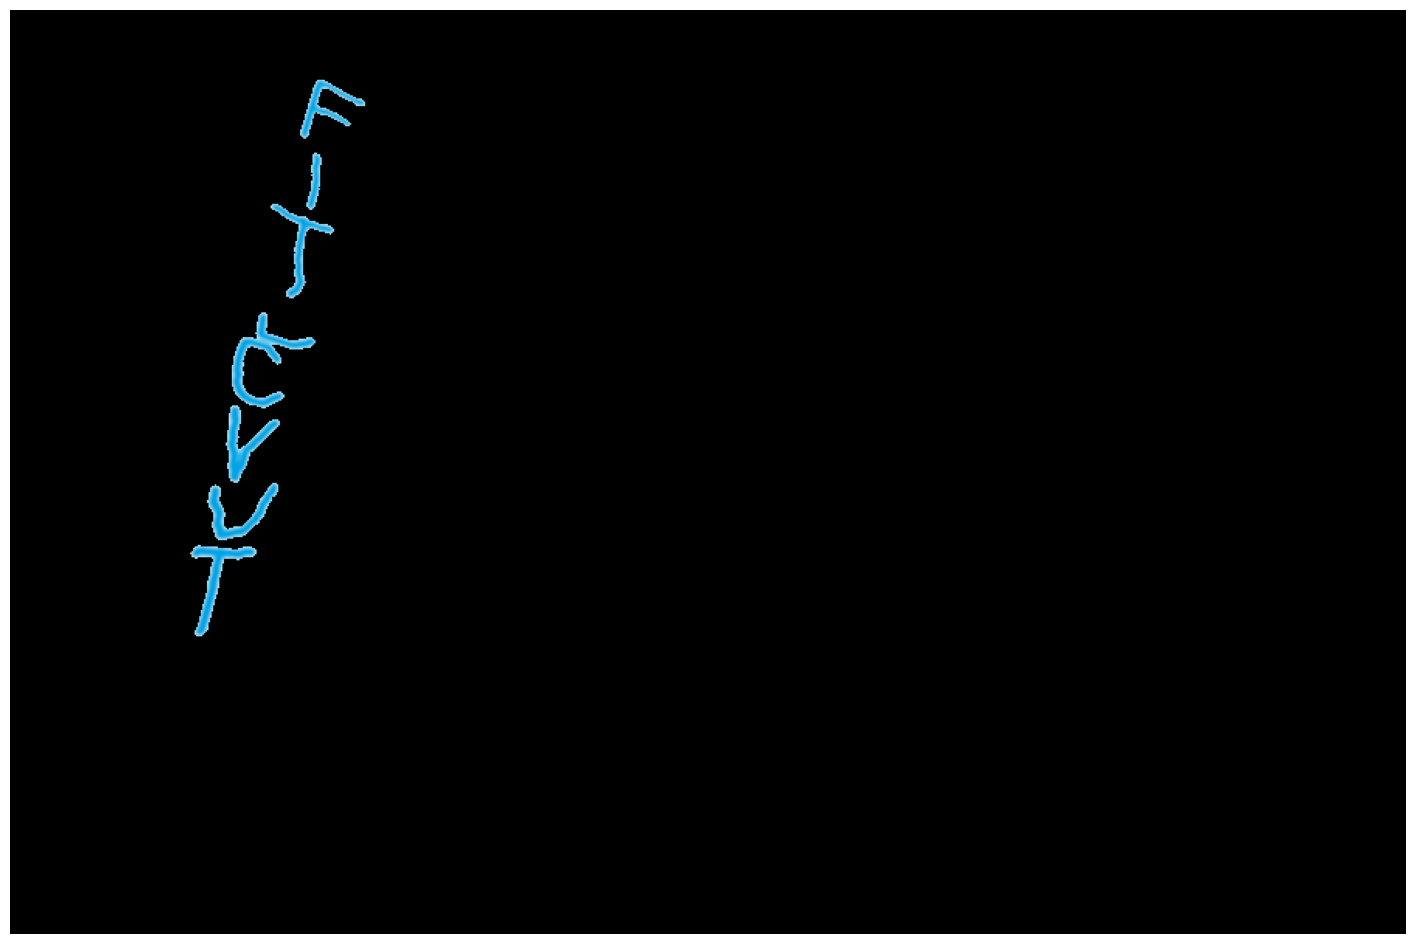

In [19]:
lower_bound1 = (to_intensity(194), 50, 25)
upper_bound1 = (to_intensity(217), 255, 243)
mask1 = segmentation_two_thresholds(to_hsv(waarp), lower_bound1, upper_bound1)
second_warp = apply_mask(waarp, mask1)
plot_images(second_warp)

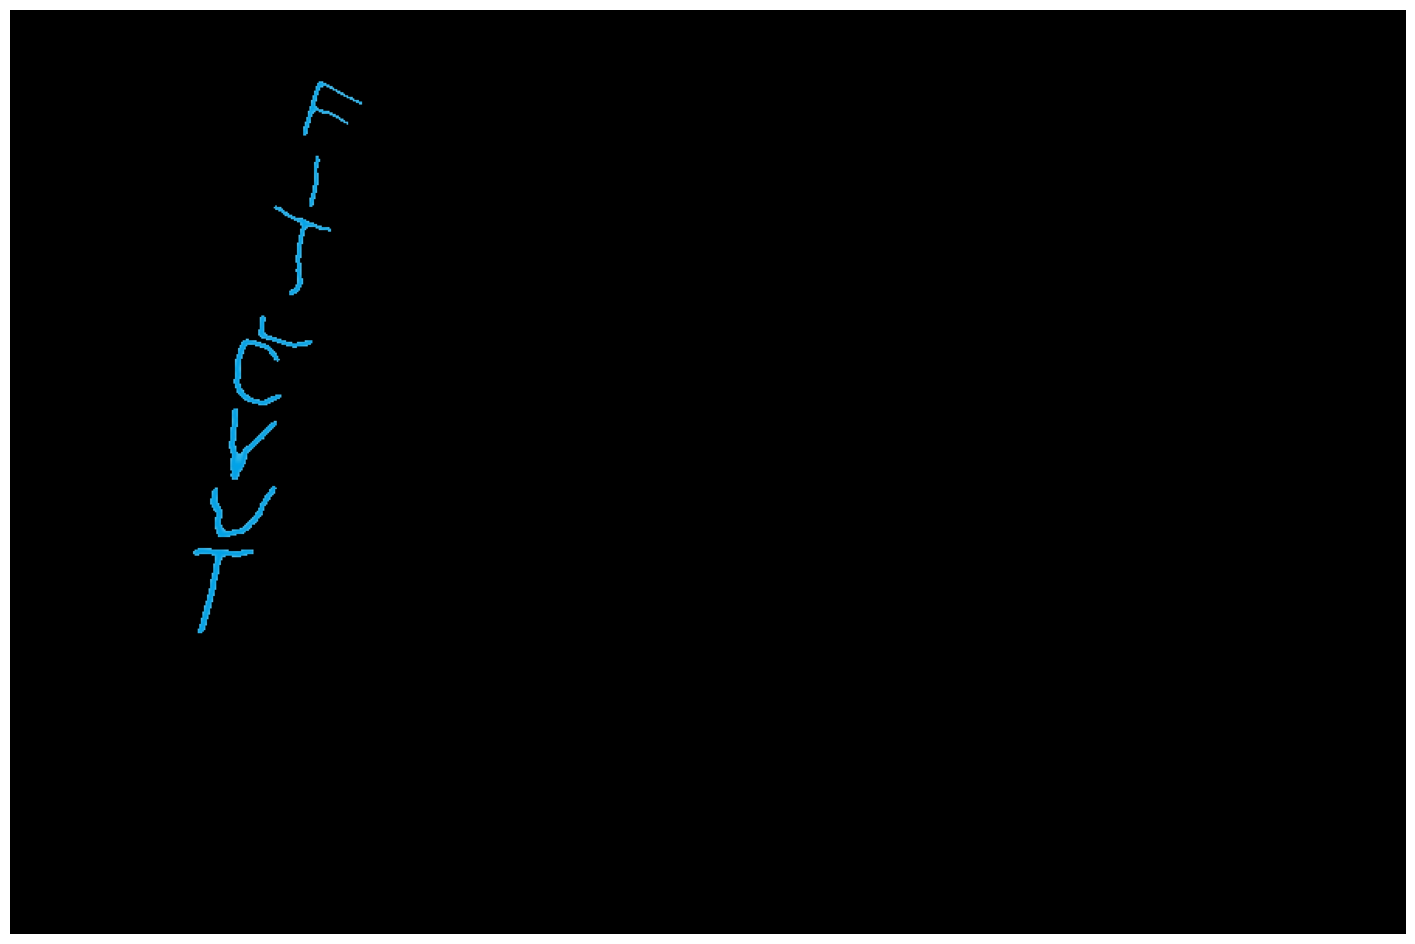

In [20]:
lower_bound2 = (0, 150, 0)
upper_bound2 = (250, 255, 80)
mask2 = segmentation_two_thresholds(second_warp, lower_bound2, upper_bound2)
overlay = apply_mask(second_warp, mask2)
plot_images(overlay)

**6) Spojte zdrojovou fotografii budovy se segmentovaným logem. Výsledek zobrazte a uložte.**

Nejedná se o žádnou složitou operaci, existuje na to přímo OpenCV funkce.

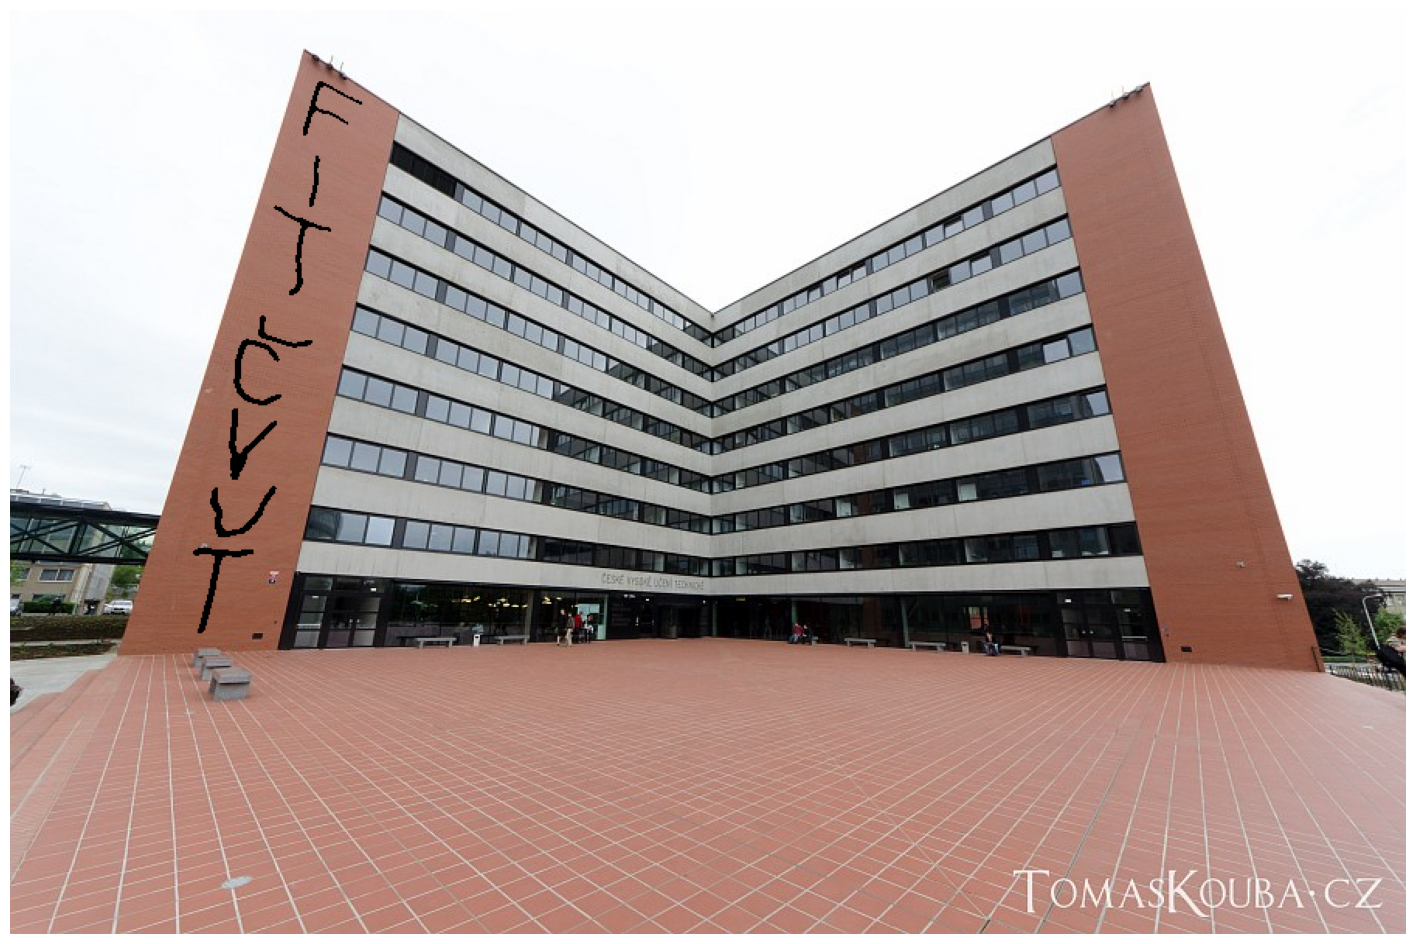

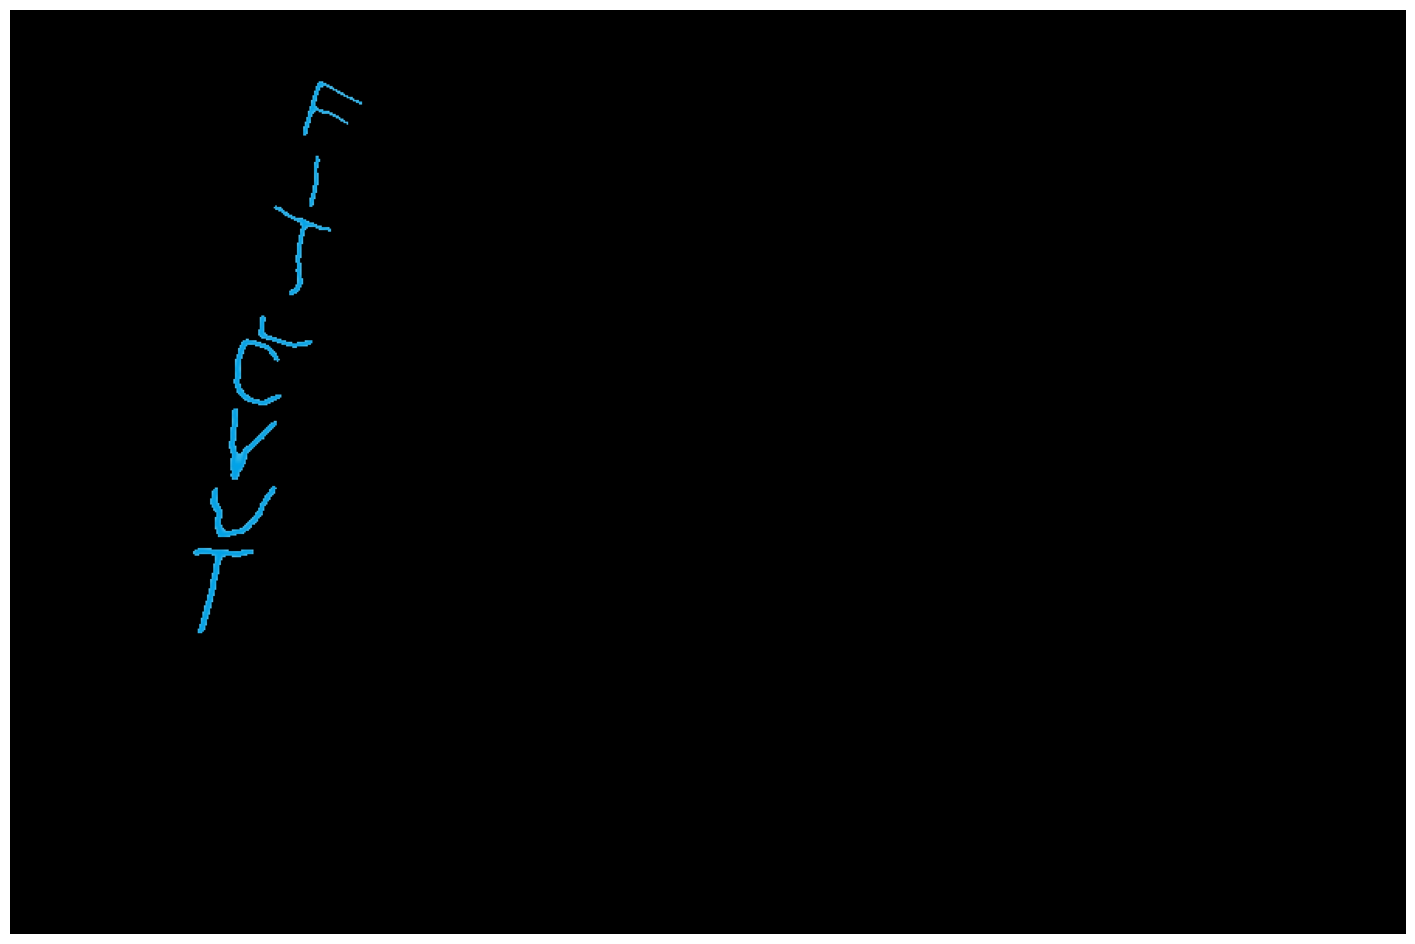

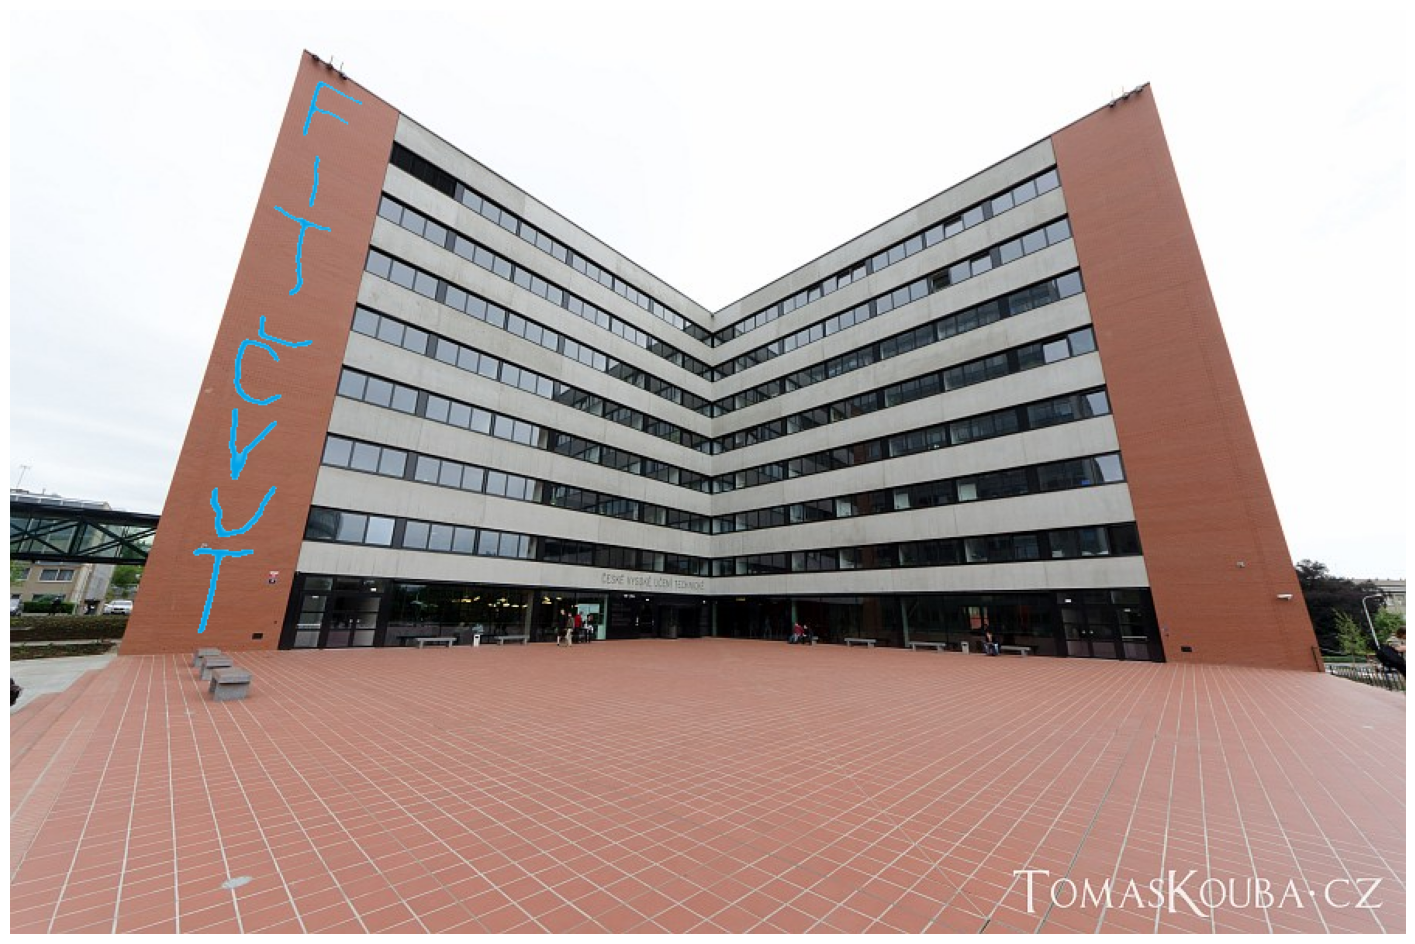

In [21]:
underlay = apply_mask(main_img, negative(mask2))
plot_images(underlay)
plot_images(overlay)
merged_img = underlay | overlay
plot_images(merged_img)

In [22]:
save_image(merged_img, "merged.png")

True

#### Bonus k druhé části
**7) Vymyslete a naprogramujte další využití perspektivní transformace pro nadcházející studenty BI-SVZ. Pro získání nápadu se lze odpíchnout od témat spojování snímků (panorama), rozšířené reality a 3D rekonstrukce. Pokud vůbec netušíte, hledejte v Google images klíčová slova "homography" nebo "perspective transform". Znovu podotýkám, že fantazii se meze nekladou a nebojte se případné dotazy/nápady konzultovat přímo s námi! <span style="color:blue">(1 bod)</span>**
